## Intro

Having trained several models trained on several different data distributions, let's plot their performace throughout the manifold, and compare to the ground truth function.

This notebook examines logspace_near_peak_narrow, which aims to capture the jump in $\phi$ and the crease in $\log A$ even better than logspace_near_peak, by concentrating the training distribution around these features.

Let's load the python modules and the model, first.

In [1]:
from utils import *
from datafile import *
from betaVAE import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'logspace_near_peak_narrow'

beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB = get_params(fname)
print([beta, latent, datasize, learning_rate, epochs, muW, muB, stdW, stdB])
ln=True

L = get_loss(fname)

model = get_model(fname)

beta,latent,datasize,learning_rate,epochs,muW,muB,stdW,stdB,ln

[0.01, 5, 2048, 0.0001, 50000, 0.0, -4.605170185988091, 0.1, 0.1]


## Learning

First, let's take a look at the learning curve, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

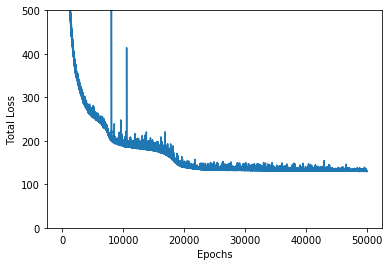

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(L)+1), L)
plt.ylim([0, 500])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")

fig

Seems like a bumpier ride than the other logspace models, but the loss seems to hvae plateaued around

In [3]:
print(L[-10:])

[130.31240844726562, 130.71034240722656, 131.6322479248047, 131.27223205566406, 131.39300537109375, 129.84982299804688, 130.18096923828125, 130.33731079101562, 130.5821533203125, 131.12640380859375]


## Behavior on Training Data; Metrics

Now that we see that the network is fully trained, let's look at several metrics of its performance on the domain where it was trained.

Let's take a look at the data itself, first.

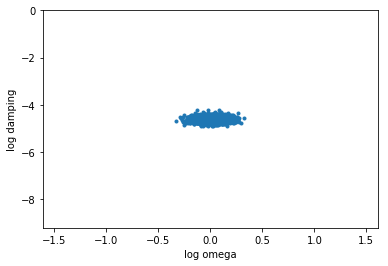

In [5]:
data, groundTruth = log_datagen(muW, muB, stdW, stdB, datasize)

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlabel("log omega")
plt.ylabel("log damping")
plt.ylim([np.log(0.0001), np.log(1)])
plt.xlim([np.log(0.2), np.log(5.0)])

fig

Now, let's compute the network's output on this data, and then compute some metrics.

In [6]:
d = torch.FloatTensor(data).cuda()

o, mu, _ = model(d)

output = o.cpu().detach().numpy()
means = mu.cpu().detach().numpy()

In [7]:
errors = output - groundTruth

phaseE = errors[:, 0]
ampE = errors[:, 1]

print(errors)

[[ 0.02452545 -0.01392806]
 [-0.00349464  0.00515264]
 [ 0.00643159  0.00418051]
 ...
 [-0.01346121 -0.01320791]
 [-0.0182791   0.00954049]
 [ 0.00223315  0.00861589]]


In [8]:
phases = groundTruth[:, 0]
amps = groundTruth[:, 1]

prange = max(phases) - min(phases)
arange = max(amps) - min(amps)

# I average the squared errors because the network is trained to minimize error**2, 
# but I compute the square root so we can compare this to the ranges.
typicalpe = np.sqrt(np.mean(phaseE**2))
typicalae = np.sqrt(np.mean(ampE**2))

print("Typical Phase Error")
print(typicalpe)
print("Typical Amp Error")
print(typicalae)

print("Typical phase error / phase range")
print(typicalpe/prange)
print("Typical amp error / amp range")
print(typicalae/arange)

Typical Phase Error
0.02332972420175735
Typical Amp Error
0.02745271470368874
Typical phase error / phase range
0.007561376059076191
Typical amp error / amp range
0.00682580668315406


So far, so good. We see the typical error on the data distribution the network was trained on. Later on, we'll also examine how the latent space was used using "means," but for now, let's try to fully understand how well this network understands the underlying function.

## Plots of The Function

### Behavior Near Training Distribution

To begin with, we will plot the groundTruth and the network approximation within the domain where it was trained ($mu \pm 2\sigma $), as well as a distribution of the errors.

In [9]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


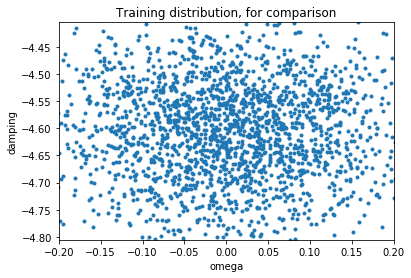

In [10]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [11]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [12]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

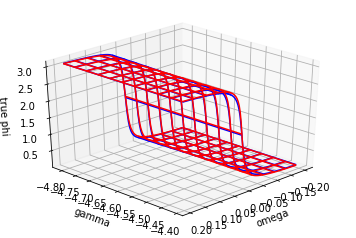

In [13]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, rstride=10, cstride=10, color="red")
ax.view_init(30, 45)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")


fig

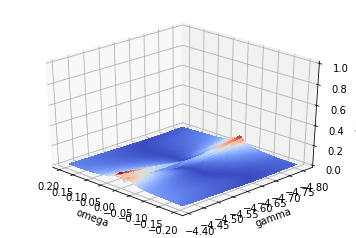

In [14]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")
ax.set_zlim([0, 1])

fig

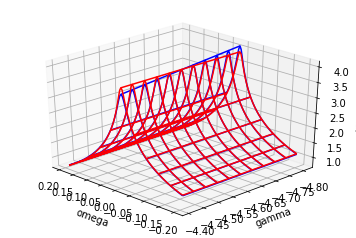

In [15]:
# Plot A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim(0, 1)

fig

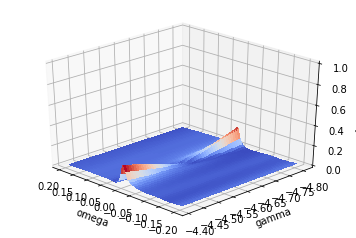

In [16]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
ax.set_zlim([0, 1])

fig

### Behavior away from the training distribution

Alright. Now how does the model perform well outside of its original domain?

In [19]:
# Make the data

wmin = np.log(0.2)
wmax = np.log(5.0)
wstep = (wmax - wmin)/100

bmin = np.log(0.001)
bmax = 0.0
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(101, 100)


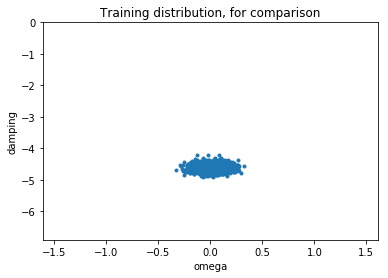

In [20]:
# Plot some training data

fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.xlim([wmin, wmax])
plt.ylim([bmin, bmax])
plt.title("Training distribution, for comparison")
plt.xlabel("omega")
plt.ylabel("damping")

fig

In [21]:
# Compute the ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

In [23]:
# Compute network output

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10100, 1), B.reshape(10100, 1)), axis=1)).cuda()

output, _, _ = model(gridpoints)

npo = output.cpu().detach().numpy()

modelPhi = npo[:, 0].reshape(101, 100)
modelA = npo[:, 1].reshape(101, 100)

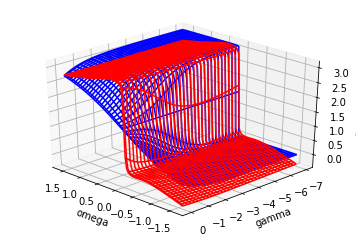

In [24]:
# Plot Phi, true and modeled

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, Phi, color="blue")
surf = ax.plot_wireframe(W, B, modelPhi, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true phi")

fig

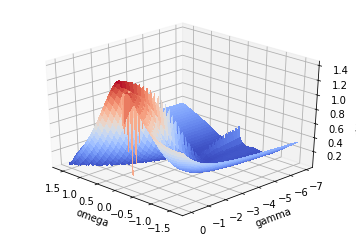

In [25]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelPhi - Phi)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("phi error")

fig

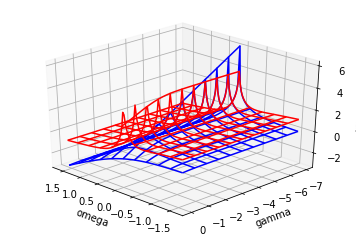

In [26]:
# Plot Ground Truth A

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, A, rstride=10, cstride=10, color="blue")
surf = ax.plot_wireframe(W, B, modelA, rstride=10, cstride=10, color="red")
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("true A")
#ax.set_zlim([0, 5])

fig

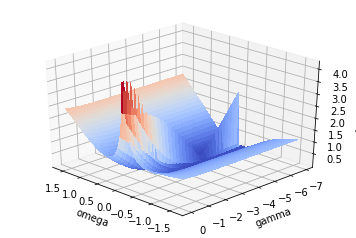

In [27]:
# Plot the L2 error

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(W, B, np.sqrt((modelA - A)**2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("A error")
#ax.set_zlim([0, 5])

fig

Now that we are looking at the extrapolation potential of the system, let's take a look at the extremes.

In [29]:
print("Max predicted phase")
print(max(modelPhi.reshape((10100,))))
print("Min predicted phase")
print(min(modelPhi.reshape((10100,))))
print("Max predicted amplitude")
print(max(modelA.reshape((10100,))))
print("Min predicted amplitude")
print(min(modelA.reshape((10100,))))

print("\n\n")

print("Max true phase")
print(max(Phi.reshape((10100,))))
print("Min true phase")
print(min(Phi.reshape((10100,))))
print("Max true amplitude")
print(max(A.reshape((10100,))))
print("Min true amplitude")
print(min(A.reshape((10100,))))

Max predicted phase
3.109149
Min predicted phase
-0.3875919
Max predicted amplitude
3.9200597
Min predicted amplitude
-0.8070114



Max true phase
3.141161161272512
Min true phase
0.000416666642554015
Max true amplitude
6.214608098422194
Min true amplitude
-3.1962732544692556


## Latent Space

Let's now look at the latent dimensions. Let's first see which are used at all during validation.

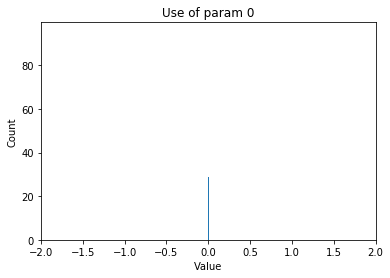

In [30]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 0], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 0")
fig

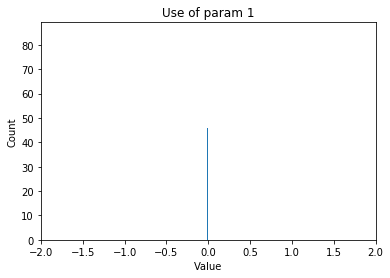

In [31]:
# Param 0 

fig = plt.figure()
plt.hist(means[:, 1], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 1")
fig

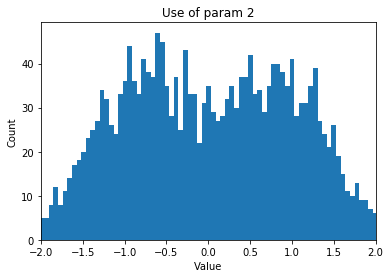

In [32]:
# Param 2

fig = plt.figure()
plt.hist(means[:, 2], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 2")
fig

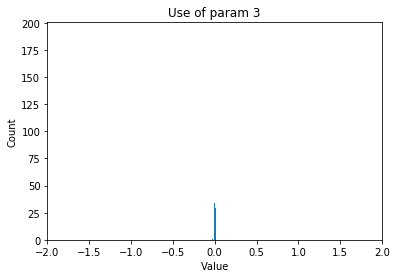

In [33]:
# Param 3

fig = plt.figure()
plt.hist(means[:, 3], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 3")
fig

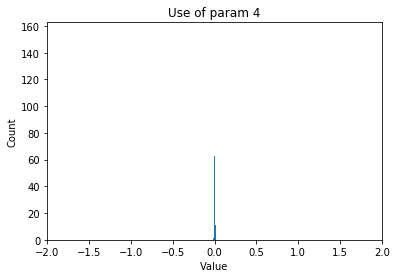

In [34]:
# Param 4

fig = plt.figure()
plt.hist(means[:, 4], 100)
plt.xlim([-2, 2])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Use of param 4")
fig

It seems that, during evaluation, only parameter $2$ is used.

Let's plot its dependence on $\omega$ and $\gamma$ within the training distribution.

In [35]:
#Make the data

wmin = muW - 2*stdW
wmax = muW + 2*stdW
wstep = (wmax - wmin)/100

bmin = muB - 2*stdB
bmax = muB + 2*stdB
bstep = (bmax - bmin)/100

w = np.arange(wmin, wmax, wstep)
b = np.arange(bmin, bmax, bstep)

W, B = np.meshgrid(w, b)

print(W.shape)

(100, 100)


In [36]:
# Compute param values

gridpoints = torch.FloatTensor(np.concatenate((W.reshape(10000, 1), B.reshape(10000, 1)), axis=1)).cuda()

output, params, _ = model(gridpoints)

npm = params.cpu().detach().numpy()
npo = output.cpu().detach().numpy()

param2 = npm[:, 2].reshape(100, 100)

modelPhi = npo[:, 0].reshape(100, 100)
modelA = npo[:, 1].reshape(100, 100)

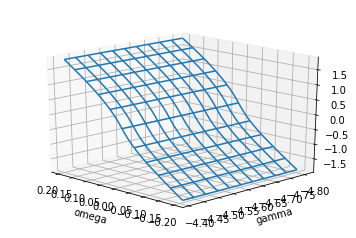

In [37]:
# Plot param 2

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_wireframe(W, B, param2, rstride=10, cstride=10)
ax.view_init(20, 135)
ax.set_xlabel("omega")
ax.set_ylabel("gamma")
ax.set_zlabel("param2")

fig

In [38]:
# Compute ground truth

Phi = phi(np.exp(W), np.exp(B))
A = np.log(amplitude(np.exp(W), np.exp(B)))

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


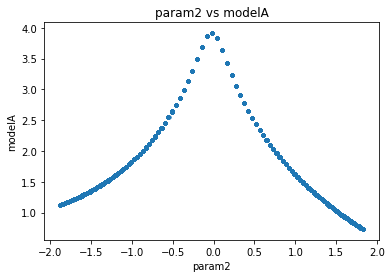

In [39]:
# Compare modelA and param2

fig = plt.figure()
plt.scatter(param2, modelA, marker='.')
plt.title("param2 vs modelA")
plt.xlabel("param2")
plt.ylabel("modelA")
fig

/home/atb86/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


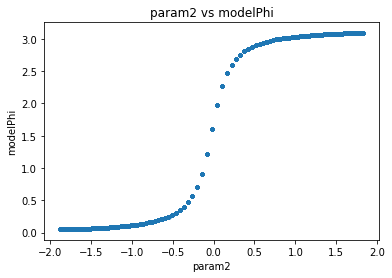

In [40]:
# Compare modelPhi and param2

fig = plt.figure()
plt.scatter(param2, modelPhi, marker='.')
plt.title("param2 vs modelPhi")
plt.xlabel("param2")
plt.ylabel("modelPhi")
fig

## Concluding Thoughts

This is perhaps the network with the simplest behavior. In the end, it only used one latent variable corresponding roughly to $\log \omega$, which only encodes the position relative to the dividing line. This is enough to encode both the central crease in $\log A$ and the jump in $\phi$, but not enough to extrapolate reasonably outside the small patch where it was trained.

It's also the one with the most informative latent space - param2 is almost linear in $\log \omega$, with a slightly steeper slope near the dividing line in order to make the separation cleaner.

Despite this simple behavior, its probably one of the least interesting networks for understanding SciNet - all it really shows is that neural networks, trained correctly, are quite good at interpolation, but they need to see the entire training dataset.